In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [101]:

# Load cleaned data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Split the data into features (X) and target (y)
X_train = train
y_train = train['SalePrice']
X_train = X_train.drop(columns=['SalePrice'])

X_test = test
y_test = test['SalePrice']
X_test = X_test.drop(columns=['SalePrice'])

In [102]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR (Linear)': SVR(kernel='linear'),
    'KNN': KNeighborsRegressor()
}

In [103]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                           RMSE        R2
Linear Regression  27200.325332  0.865512
Ridge Regression   27199.988421  0.865515
Lasso Regression   27200.307499  0.865512
ElasticNet         28150.091087  0.855956
Decision Tree      33641.900126  0.794270
Random Forest      23469.442500  0.899875
Gradient Boosting  21640.425645  0.914873
SVR (Linear)       32684.084644  0.805818
KNN                35128.918129  0.775681


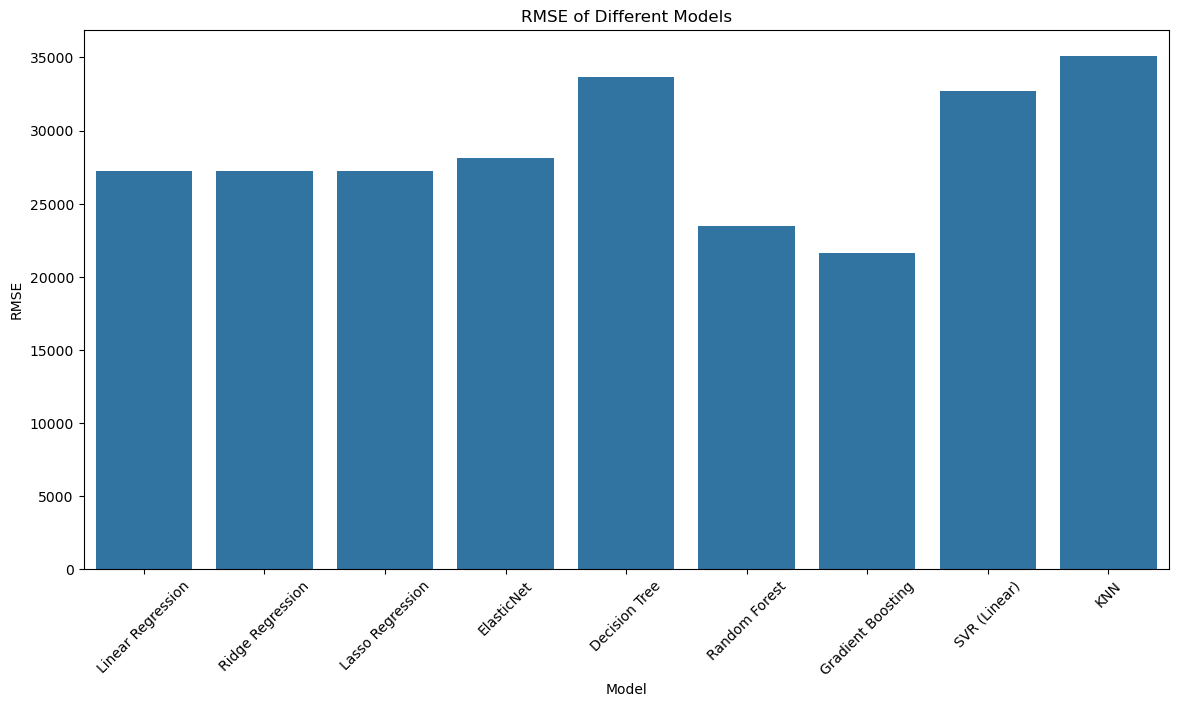

In [104]:
# Plotting the performance of the models
plt.figure(figsize=(14, 7))
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.title('RMSE of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

In [108]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define models and parameter grids for hyperparameter tuning
models_param_grids = {
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    '''
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    }, 
    'SVR (Linear)': {
        'model': SVR(kernel='linear'),
        'param_grid': {
            'C': [0.1, 1, 10, 100]
        }
    },
    '''   
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    }
}

# Perform hyperparameter tuning for each model
best_models = {}
for name, mp in models_param_grids.items():
    grid_search = GridSearchCV(mp['model'], mp['param_grid'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train if name in ['SVR (Linear)', 'KNN'] else X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models
best_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_results[name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}

# Compare with Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Display comparison results
comparison_results = {
    'Linear Regression': {'RMSE': rmse_lr, 'MAE': mae_lr, 'R^2': r2_lr},
    'Tuned Decision Tree': best_results['Decision Tree'],
    #'Tuned Random Forest': best_results['Random Forest'],
    #'Tuned Gradient Boosting': best_results['Gradient Boosting'],
    #'Tuned SVR (Linear)': best_results['SVR (Linear)'],
    'Tuned KNN': best_results['KNN']
}

comparison_results_df = pd.DataFrame(comparison_results).T
print(comparison_results_df)

# Plotting the performance of the models
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='RMSE', data=comparison_results_df)
plt.title('RMSE Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

# Plotting the performance of the models using MAE
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='MAE', data=comparison_results_df)
plt.title('MAE Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()

# Plotting the performance of the models using R²
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='R^2', data=comparison_results_df)
plt.title('R² Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.show()

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best parameters for 
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    }, 
    'SVR (Linear)': {
        'model': SVR(kernel='linear'),
        'param_grid': {
            'C': [0.1, 1, 10, 100]
        }
    },
    KNN: {'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'distance'}


KeyError: 'KNN'